## Comparing Value and Likelihood Function to calculate Regret


In [23]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [24]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)
from src.utils.visualization import (
    plot_posterior_distribution,
    plot_environment,
    plot_trajectories,
    plot_log_likelihood,
)
from src.utils.constants import ParamTuple
from src.utils.optimization import soft_q_iteration
from src.utils.inference.rollouts import generate_n_trajectories

np.set_printoptions(linewidth=160, precision=2)

Create Environment


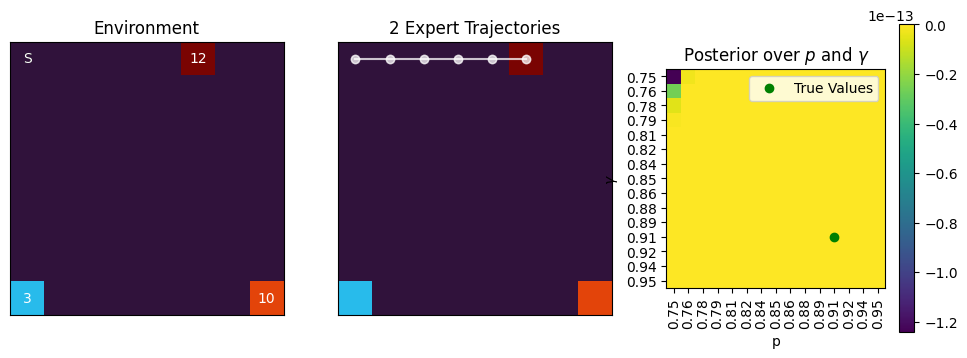

In [61]:
# 0. Setup
## 0.1 Setup the experiment
n_env_samples = 15
n_posterior_samples = 10
n_traj_per_sample = 2

## 0.2 Setup the environment
N, M = 8, 8
n_states, n_actions = N * M, 4

# TODO describe world
agent_R = np.zeros((N, M))
agent_R[0, M-3] = 12
agent_R[N-1, 0] = 3
agent_R[N-1, M-1] = 10


# Start by making the agent we want to learn the policy of
agent_p = 0.9
agent_gamma = 0.9
p_true=1

agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)

n_samples_MC = 1_000
n_burnin_MC = 500

# Generate 2 trajectories in the env starting environment
wall_states = []
T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=1000)

env_agent = Environment(
    N=N,
    M=M,
    T_true=T_true,
    wall_states=wall_states,
    R_sample_mean=None,
    start_state=0,
    n_walls=None,
)

# Generate trajectories
trajectories = generate_n_trajectories(
    env_agent.T_true,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

expert_trajectories_1 = [(env_agent, trajectories)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

plot_log_likelihood(
    param_values=true_params,
    expert_trajectories=expert_trajectories_1,
    goal_states=goal_states,
    ax=ax3,
)

## Create Candidate Environments, insert a wall state in each goal state

We consider all permutations of the goal states, so if there are $N$ goal states, we insert 2^N different wall combinations.


In [62]:
def powerset(s):
    pset = []
    x = len(s)
    for i in range(2 << x):
        pset.append([s[j] for j in range(x) if (i & (1 << j))])
    return pset


# insert wall in each goal state s.t. expert can no longer execute strategy
_goal_states_list = list(np.where(agent_R > 0)[0])
_goal_states_list = powerset(_goal_states_list)
_goal_states_list = _goal_states_list[: (int(len(_goal_states_list) / 2))]
# create candidate environment
candidate_envs = [
    Environment(
        N=N,
        M=M,
        T_true=T_true,
        wall_states=wall_states,
        R_sample_mean=None,
        start_state=0,
        n_walls=None,
    )
    for _ in range(len(_goal_states_list))
]

for idx, candidate_env in enumerate(candidate_envs):
    # update T
    _T = insert_walls_into_T(
        candidate_env.T_true, wall_indices=[_goal_states_list[idx]]
    )
    candidate_env.T_true = _T

    #append wall to list of walls of that environment
    candidate_env.wall_states = _goal_states_list[idx]

candidate_envs = candidate_envs[:-1] #delete last permutation where we block off all goal states as the MDP makes no more sense th<n

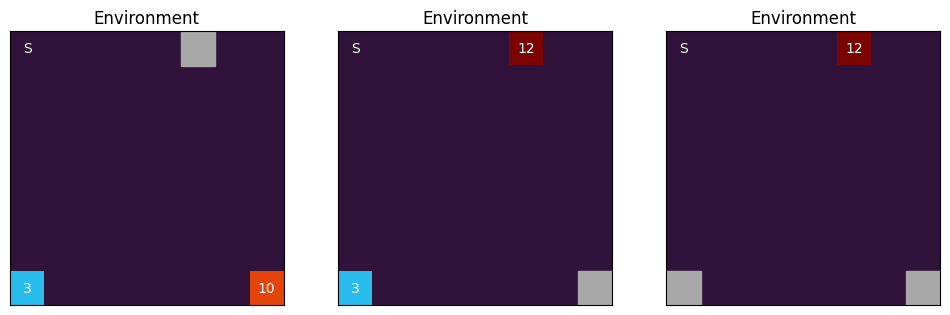

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot_environment(agent_R.reshape(N, M), candidate_envs[1].wall_states, ax=ax1)
plot_environment(agent_R.reshape(N, M), candidate_envs[4].wall_states, ax=ax2)
plot_environment(agent_R.reshape(N, M), candidate_envs[6].wall_states, ax=ax3)

Calculate potential Posterior in candidate environment if we had 2 expert trajectories in that environment.


In [64]:
from src.utils.constants import ParamTuple, gamma_limits, p_limits, R_limits, StateTransition
from src.utils.make_environment import Environment
from src.utils.inference.likelihood import expert_trajectory_log_likelihood
# from .make_environment import Environment
# from .inference.likelihood import expert_trajectory_log_likelihood

In [72]:
def plot_log_likelihood(param_values: ParamTuple, 
                        expert_trajectories: list[tuple[Environment, list[StateTransition]]], 
                        goal_states: list,
                        ax = None
                        ):

    '''
    Plots the posterior distribution of $p$ and $\gamma$ holding R constant.

    Args:
    --param_values, ParamTuple: Containing the values for the posterior
    --expert trajectories: list of tuples containing environments and their respective expert environments
    --goal_states: list of goal states, flattened
    '''
    if ax is None:
        _, axs = plt.subplots()
    else:
        axs = ax
    n_samples_per_axis = 15

    gammas = np.linspace(0.75, 0.95, n_samples_per_axis)
    ps = np.linspace(0.75, 0.95, n_samples_per_axis)

    likelihoods = np.zeros(shape = (n_samples_per_axis, n_samples_per_axis))

    for idx_p, p in enumerate(ps):
        for idx_gamma, gamma in enumerate(gammas): #only up to 0.95 because it gets unstable for higher gamma

            proposed_parameter = ParamTuple(p=p, gamma=gamma, R=param_values.R)

            likelihood = expert_trajectory_log_likelihood(
                proposed_parameter, expert_trajectories, goal_states
            )
            likelihoods[idx_p, idx_gamma] = likelihood


    index_p_true = (np. abs(ps - param_values.p)). argmin()
    index_gamma_true = (np. abs(gammas - param_values.gamma)). argmin()

    im = axs.imshow(
        likelihoods, cmap="viridis", origin="upper"
    )
    plt.colorbar(im, orientation="vertical")
    axs.set_ylabel("p")
    axs.set_xlabel("$\gamma$")
    axs.set_xticks(np.arange(n_samples_per_axis), np.round(ps, 2), rotation='vertical')
    axs.set_yticks(np.arange(n_samples_per_axis), np.round(gammas, 2))
    axs.set_title(f"Posterior over $p$ and $\gamma$")
    plt.plot(index_p_true, index_gamma_true, "og", label = "True Values")
    axs.legend()

In [66]:
def plot_posterior_for_env(env: Environment):
    print("Regret: ", env.regret)
    print("Log Regret: ", env.log_regret)
    print("Wall States: ", env.wall_states)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
    T_true = insert_walls_into_T(T_true, wall_indices=env.wall_states)
    env.T_true = T_true
    T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
    T_agent = insert_walls_into_T(T_agent, wall_indices=env.wall_states)
    agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=1000)

    # Generate trajectories
    trajectories = generate_n_trajectories(
        env.T_true,  # shouldnt this be T_true?
        agent_policy,
        goal_states,
        n_trajectories=2,
    )

    expert_trajectories_1 = [(env, trajectories)]

    plot_environment(
        agent_R.reshape(N, M),
        env.wall_states,
        start_state=(env.start_state // M, env.start_state % M),
        ax=ax1,
    )

    # Show the trajectories
    plot_trajectories(N, M, trajectories, agent_R, ax=ax2)

    # Remove the colorbar from the second plot
    ax2.get_images()[0].colorbar.remove()

    plot_log_likelihood(
        param_values=true_params,
        expert_trajectories=expert_trajectories_1,
        goal_states=goal_states,
        ax=ax3,
    )

Posterior sampling:   0%|          | 0/1000 [00:00<?, ?it/s, Acceptance rate=66.7, step_size=0.1]

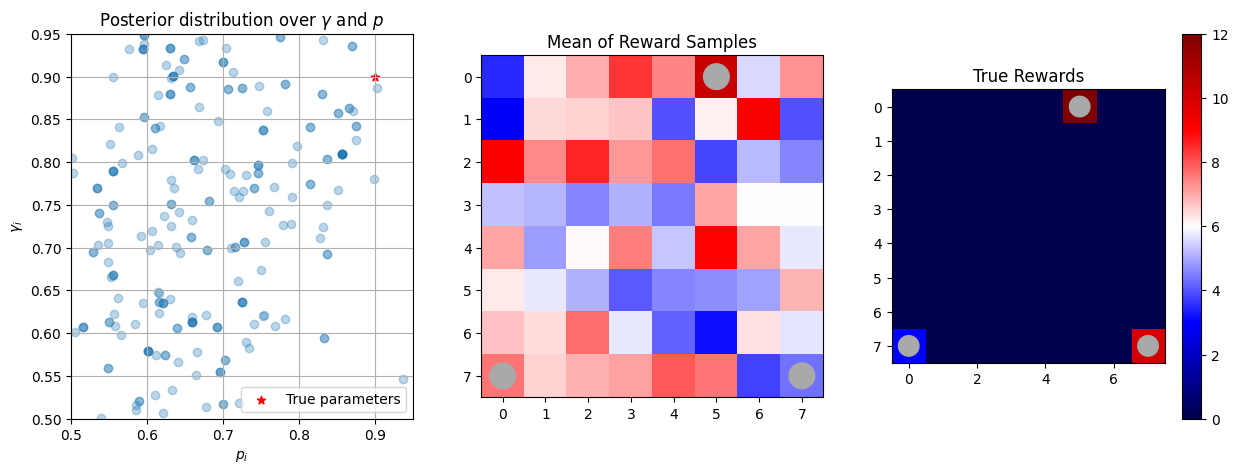

In [67]:
from src.utils.inference.sampling import bayesian_parameter_learning
from src.utils.environment_design import environment_search

posterior_samples_1 = bayesian_parameter_learning(
    expert_trajectories=expert_trajectories_1,
    sample_size=n_samples_MC,
    goal_states=goal_states,
    n_states=n_states,
)
posterior_samples_1 = posterior_samples_1[-250:]

plot_posterior_distribution(
    posterior_samples=posterior_samples_1,
    N=N,
    M=M,
    absorbing_states=goal_states,
    true_params=true_params,
)

## Calculate likelihood and value based regret for this environment


Calculate the regret of the environments using the value function

We learn only p and gamma


In [68]:
envs_value = environment_search(
    N=N,
    M=M,
    goal_states=goal_states,
    posterior_samples=posterior_samples_1,
    n_traj_per_sample=2,
    candidate_envs=candidate_envs,
    how="value",
    agent_R=agent_R,
)

Evaluating candidate environments using value: 100%|██████████| 7/7 [01:37<00:00, 13.98s/it, highest_regret=0.122]


Calculate the regret of the environments using the likelihood function


In [69]:
envs_likelihood = environment_search(
    N=N,
    M=M,
    goal_states=goal_states,
    posterior_samples=posterior_samples_1,
    n_traj_per_sample=2,
    candidate_envs=candidate_envs,
    how="likelihood",
    agent_R=agent_R,
)

Evaluating candidate environments using likelihood:  43%|████▎     | 3/7 [01:15<01:37, 24.49s/it, highest_log_regret=4.28, wall_states=[5]]

action probabilities:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum action probabilities:  0.0
action probabilities:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum action probabilities:  0.0
action probabilities:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum action probabilities:  0.0
action probabilities:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sum action probabilities:  0.0
acti

Evaluating candidate environments using likelihood: 100%|██████████| 7/7 [04:06<00:00, 35.24s/it, highest_log_regret=4.28, wall_states=[5]]


Plot highest and lowest regret environments for value and likelihood

Top 4 environments according to value -> these are bad

Regret:  0.12175872069111587
Log Regret:  3.922123148567601
Wall States:  [56, 63]


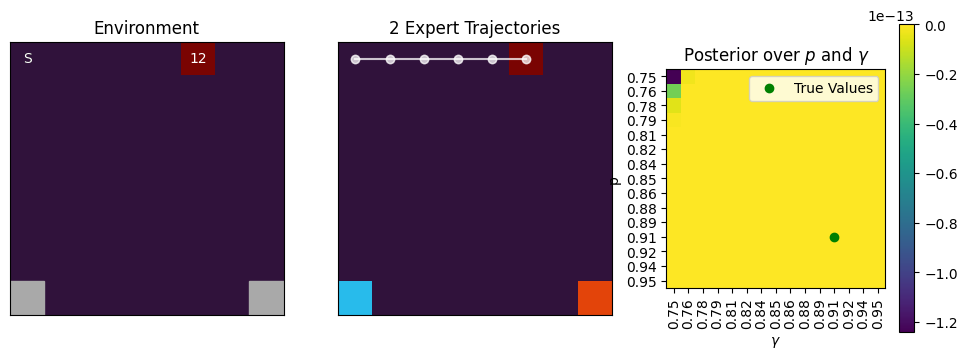

In [73]:
plot_posterior_for_env(envs_value[0])

Regret:  0.04511189785576064
Log Regret:  4.283377919762745
Wall States:  [5]


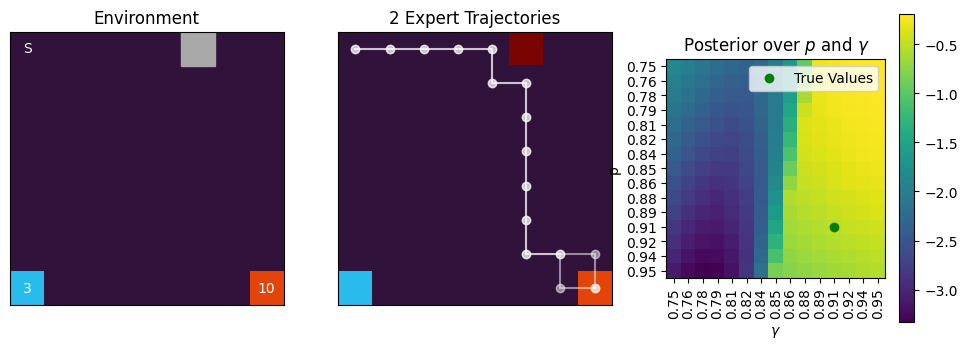

In [74]:
plot_posterior_for_env(envs_likelihood[0])
# plot_posterior_for_env(envs_likelihood[1])
# plot_posterior_for_env(envs_value[0])
# plot_posterior_for_env(envs_value[1])